In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 23a: Lecture

##  Convolutional Neural Network (CNN)
- L2 Regularization
- Fashion MNIST
- Dataset From CSV File

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
  
%matplotlib inline

2023-12-04 13:15:20.914554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 13:15:20.914590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 13:15:20.915584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 13:15:20.920842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 13:15:21.598082: W tensorflow/compiler/tf2

In [4]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'cnn_do'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

ALPHA = 0.001
EPOCHS = 50 # number of cycles to run
PATIENCE = 20
LR_PATIENCE = 10
FACTOR_LR = 0.5
BATCH_SIZE = 32 # inline of Training Rows being 60000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-12-04 13:15:22.280099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 13:15:22.311045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 13:15:22.311281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper Function

In [7]:
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(_path, ' exists') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print("Created folder : ", _path)

In [8]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [9]:
def fn_plot_label(train_df : pd.DataFrame, test_df : pd.DataFrame):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [10]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [11]:
train_filename = os.path.join(inpDir, subDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, subDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [12]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


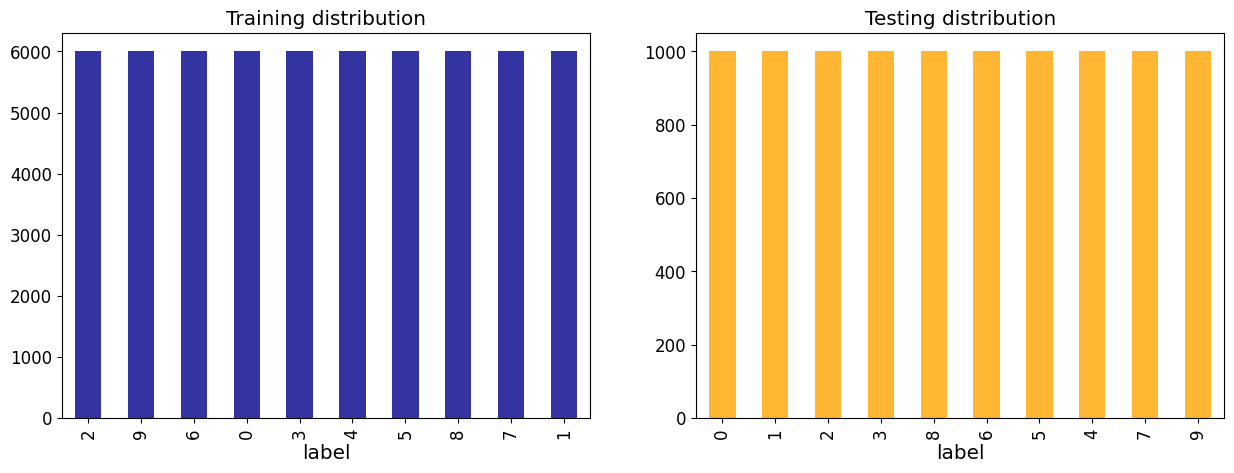

In [14]:
fn_plot_label(train_df, test_df)

## Converting to Datasets

In [15]:
def fn_split_features_labels(row):

    feature = tf.reshape(row[1:], [28,28,1])
    
    label = row[0]
    
    return feature, label

In [16]:
# images[0]

In [17]:
# Create a training dataset

###--------------
### Training Data
###--------------
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(fn_split_features_labels)

train_ds = train_ds.batch(BATCH_SIZE)

###--------------
### Testing Data
###--------------
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(fn_split_features_labels)

test_ds = test_ds.batch(BATCH_SIZE)

2023-12-04 13:15:25.755965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 13:15:25.756424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 13:15:25.756644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

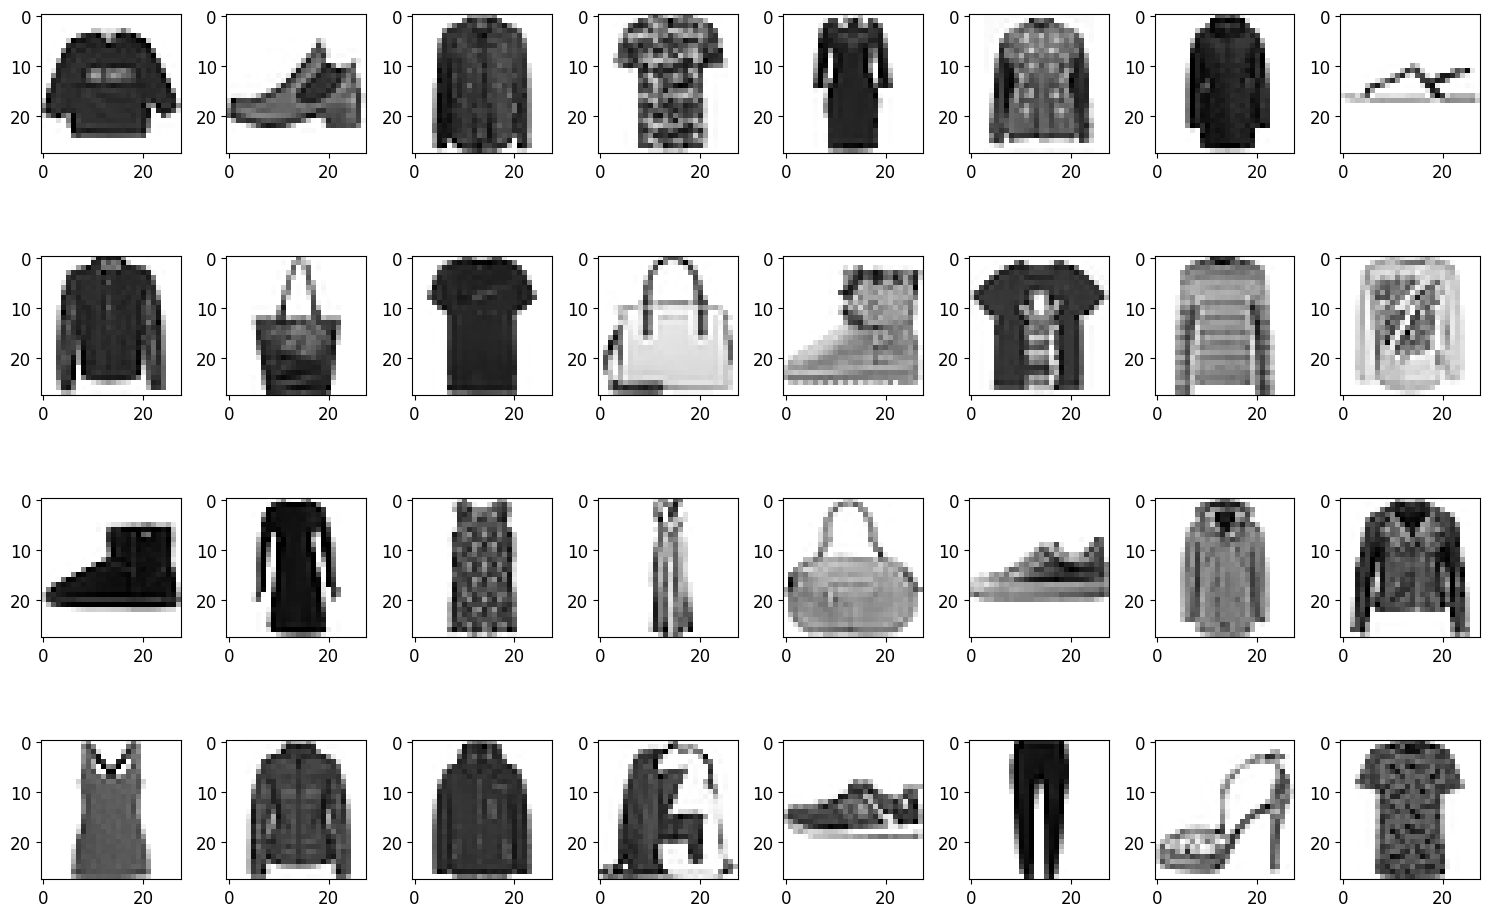

In [18]:
for images, labels in train_ds.take(1):

    #print(images.shape, labels)

    for i in range(BATCH_SIZE):

        rows = 4
        plt.subplot(rows, BATCH_SIZE//rows, i+1 )
    
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        plt.grid(False)
        
    plt.tight_layout()

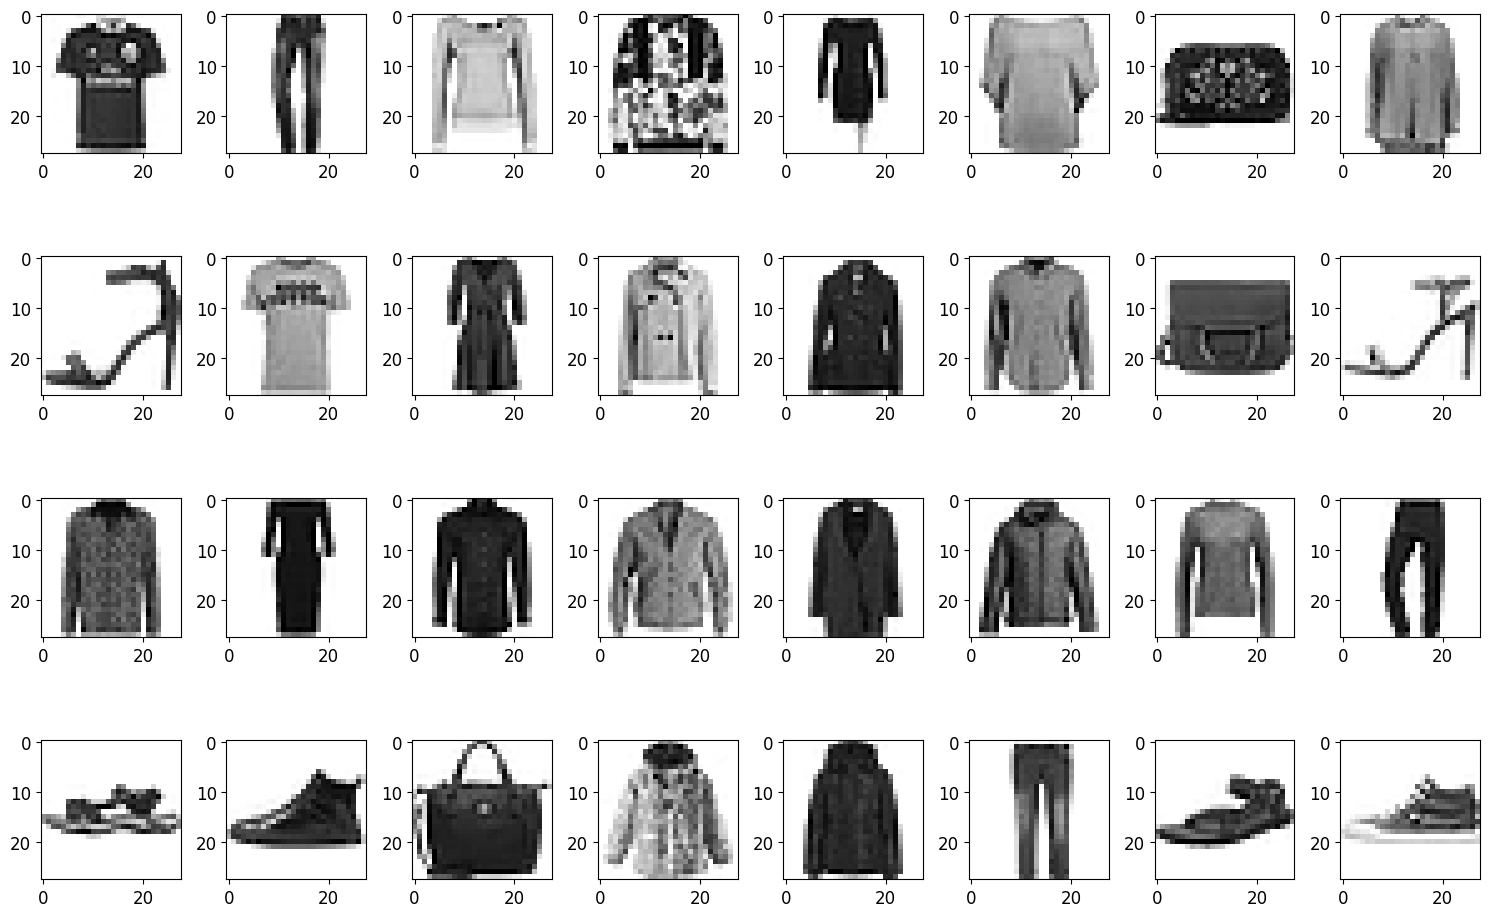

In [19]:
for images, labels in test_ds.take(1):

    #print(images.shape, labels)

    for i in range(BATCH_SIZE):

        rows = 4
        plt.subplot(rows, BATCH_SIZE//rows, i+1 )
    
        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        plt.grid(False)
        
    plt.tight_layout()

In [20]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Rescaling(1/255.), # 28, 28, 3
    
    ###------
    ### Set 1
    ###------
    # Conv layer
    tf.keras.layers.Conv2D(32, (3,3),
                           padding='same',
                           activation='relu',
                           kernel_regularizer='l2',
                           input_shape = (28,28,1)), # 28 x 28 x 32
    # Pooling
    tf.keras.layers.MaxPooling2D( (2,2)), # 14 x 14 x 32
                    
    ###------
    ### Set 2
    ###------
    # Conv layer
    tf.keras.layers.Conv2D(64, (3,3),
                           kernel_regularizer='l2',
                           activation='relu'), # 12 x 12 x 64
    # Pooling
    tf.keras.layers.MaxPooling2D( (2,2)), # 6 x 6 x 64

    ###------
    ### Set 3
    ###------
    # Conv 3
    tf.keras.layers.Conv2D(128, (3,3),
                           kernel_regularizer='l2',
                           activation='relu'), # 4 x 4 x 128

    tf.keras.layers.Flatten(),
    
    ###-------------
    ### Dense Layers
    ###-------------
    # Dense 1
    tf.keras.layers.Dense(512,
                          kernel_regularizer='l2',
                          activation='relu'),
    
    # Dense 2
    tf.keras.layers.Dense(10)

])


In [22]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True,
    verbose = 1)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)

In [23]:
optim = tf.keras.optimizers.Adam(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optim, loss = loss_fn, metrics=['accuracy'])

In [24]:
history = model.fit(train_ds, validation_data=test_ds, 
                    epochs=EPOCHS, 
                    verbose=1, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[early_stopping_callback, lr_decay]
                   )

Epoch 1/50


2023-12-04 13:15:31.171266: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-04 13:15:31.232805: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-04 13:15:31.454450: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-04 13:15:31.510102: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f19d0fdf6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 13:15:31.510136: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-04 13:15:31.514873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701675931.573102   15266 devic

1875/1875 [==============================] - 7s 3ms/step - loss: 0.9965 - accuracy: 0.7719 - val_loss: 0.7249 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.7038 - accuracy: 0.8209 - val_loss: 0.6572 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 3/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6499 - accuracy: 0.8342 - val_loss: 0.6218 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 4/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6219 - accuracy: 0.8402 - val_loss: 0.5938 - val_accuracy: 0.8497 - lr: 0.0010
Epoch 5/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6025 - accuracy: 0.8435 - val_loss: 0.5811 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5875 - accuracy: 0.8465 - val_loss: 0.5615 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step -

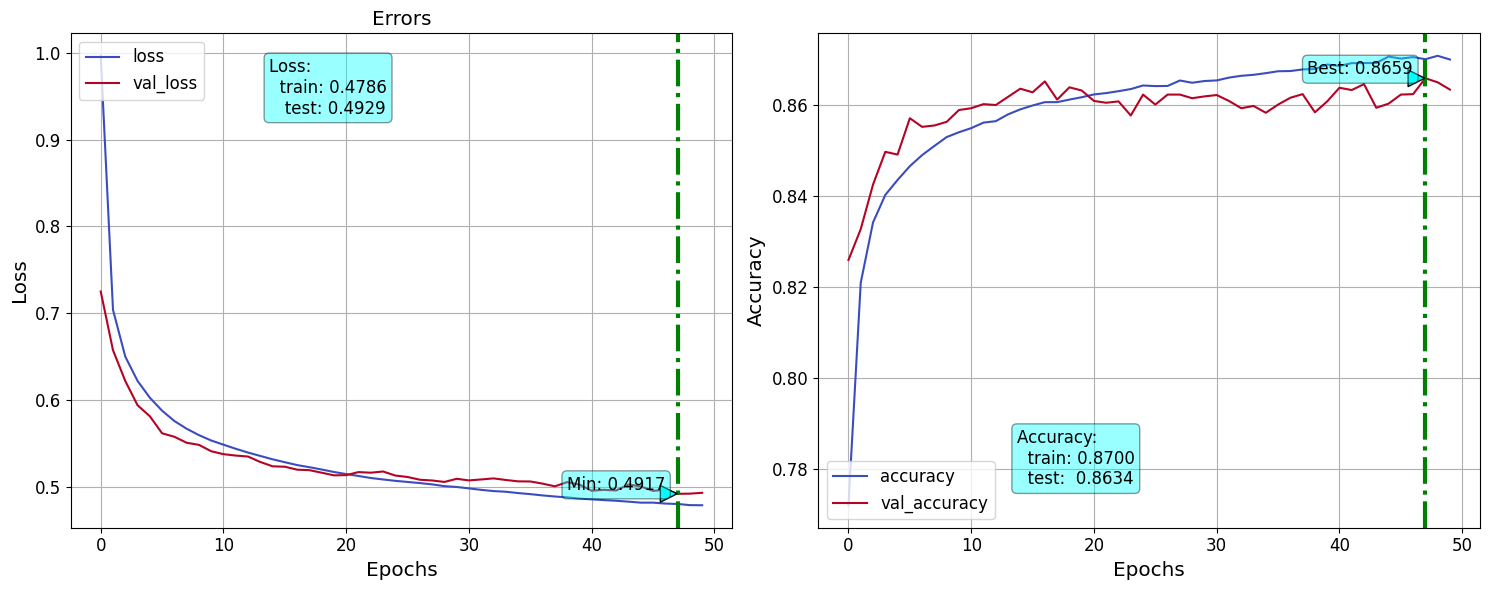

In [25]:
loss_df = pd.DataFrame(history.history)

fn_plot_tf_hist(loss_df)

In [ ]:
# Each row need to be seperated in features and labels
def split_feature_label(row ):
    '''
    Args:
        row: array of 785 values
    returns:
        feature : np.ndarray of shape (28 x 28, 1)
        label: integer
    '''
    
    feature = tf.reshape(row[1:], [28, 28, 1])
    
    label = row[0]
    
    return feature, label

In [ ]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


In [ ]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

### Rescaling of images

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

image_batch, labels_batch = next(iter(train_ds))

img = image_batch[0].numpy()

print ('Original Image--- Min pixel:', img.min(), ' | Max pixel:', img.max())

print ('-'*50)


# apply it to the dataset by calling map

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))

img = image_batch[0].numpy()

print ('Normalized Image--- Min pixel:', img.min(), ' | Max pixel:', img.max())

In [ ]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Convolution Layer in Action

In [ ]:
input_shape = (1, 6, 6, 1)
X = tf.random.normal(input_shape)
#X = tf.fill(input_shape, 1.0)
X.shape

In [ ]:
import seaborn as sns

sns.heatmap(X.numpy()[0,:,:,0], annot=True, fmt=".2f");

In [ ]:
2.1-0.13-0.15+1.48-1.48+0.92-1.69+1.42-.72+0.72-0.06+1.49+1-0.42+1.36-0.19

In [ ]:
tf.constant_initializer(1.).value

In [ ]:
y = tf.keras.layers.Conv2D(1, 3,
                           kernel_initializer=tf.constant_initializer(1.),
                           use_bias = False,
                           activation='relu', 
                           input_shape=input_shape[1:])(X)
y.shape

Arguments|Description
:--|:--
filters|Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
kernel_size|An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
strides|An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
padding|one of "valid" or "same" (case-insensitive).
data_format|A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch_size, height, width, channels) while channels_first corresponds to inputs with shape (batch_size, channels,height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be channels_last.
dilation_rate|an integer or tuple/list of 2 integers, specifying the dilation rate to use for dilated convolution. Can be a single integer to specify the same value for all spatial dimensions. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any stride value != 1.
groups|A positive integer specifying the number of groups in which the input is split along the channel axis. Each group is convolved separately with filters / groups filters. The output is the concatenation of all the groups results along the channel axis. Input channels and filters must both be divisible by groups.
activation|Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
use_bias|Boolean, whether the layer uses a bias vector.
kernel_initializer|Initializer for the kernel weights matrix (see keras.initializers).
bias_initializer|Initializer for the bias vector (see keras.initializers).
kernel_regularizer|Regularizer function applied to the kernel weights matrix (see keras.regularizers).
bias_regularizer|Regularizer function applied to the bias vector (see keras.regularizers).
activity_regularizer|Regularizer function applied to the output of the layer (its "activation") (see keras.regularizers).
kernel_constraint|Constraint function applied to the kernel matrix (see keras.constraints).
bias_constraint|Constraint function applied to the bias vector (see keras.constraints).

In [ ]:
sns.heatmap(y.numpy()[0,:,:,0], annot=True, fmt=".2f");

In [ ]:
2.1-0.13-0.15+1.48-1.48+0.92-1.69+1.42-.72

### What if I use even size filter
Purely, from math perspective, you can use even size filters. But Even-sized filters (like 2x2, 4x4) do not have a single center pixel, which can make certain operations less intuitive. For example, it might be less clear how to pool or downsample the outputs of such filters.

In [ ]:
z = tf.keras.layers.Conv2D(1, 4,
                           kernel_initializer=tf.constant_initializer(1.),
                           use_bias = False,
                           activation='relu', 
                           input_shape=input_shape[1:])(X)
z.shape

In [ ]:
sns.heatmap(z.numpy()[0,:,:,0], annot=True, fmt=".2f");

## MaxPool Layer in Action

In [ ]:
max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                           strides=(2, 2), 
                                           padding='valid')

z = max_pool_2d(y)

sns.heatmap(z.numpy()[0,:,:,0], annot=True, fmt=".2f");

## Pooling Layer
>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

Arguments|Description
:--|:--
pool_size|integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window. If only one integer is specified, the same window length will be used for both dimensions.
strides|Integer, tuple of 2 integers, or None. Strides values. Specifies how far the pooling window moves for each pooling step. If None, it will default to pool_size.
padding|One of "valid" or "same" (case-insensitive). "valid" adds no zero padding. "same" adds padding such that if the stride is 1, the output shape is the same as input shape.
data_format|A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, height, width, channels) while channels_first corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".

### Create the Convolution base

<img src = '../../images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

>tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)

>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

In [ ]:
# dropout rates
dor1 = 0.1

# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Rescaling(1./255) )
#############
### Set 1 ###
#############
# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(28, 28, 1))) # (28 x 28 x 32)
# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (14 x 14 x 32)

# Dropout 
model.add(tf.keras.layers.Dropout(rate = dor1)


# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu')) # (12 x 12 x 64)

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 6 x 6 x 64)

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 4 x 4 x 128)

In [ ]:
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dense 2
model.add(tf.keras.layers.Dense(10))

In [ ]:
# Early stopping call back
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)
# define model file path
modelFile = os.path.join(modelDir, subDir, altName)
# define checkpoint callback
model_callback = tf.keras.callbacks.ModelCheckpoint(
    modelFile,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto',
    )

# define learning rate callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1
)


### Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_ds,
                   callbacks=[early_callback, model_callback, lr_callback])

In [ ]:
model.summary()

In [ ]:
res_df = pd.DataFrame(history.history)
res_df.head()

In [ ]:
fn_plot_tf_hist(res_df)

### Evaluate the model

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

In [ ]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [ ]:
yhat = model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print(f'Accuracy score on Test Data : {accuracy_score(y_test, y_pred) : .4f}')


|| |Predicted| class
|:-|:-|:-|:-|
| | |P|N|
Actual|P|TP|FN
class|N|FP|TN

In [ ]:
CMAP = plt.cm.Blues

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap=CMAP, colorbar=False, xticks_rotation=90);

In [ ]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

fntsize = 12

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row[0]!= row[-1]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_labels[row[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_labels[row[-1]], transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\nIncorrect classes are marked in red.')
plt.tight_layout()
plt.show()